Import libraries

In [0]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tqdm.notebook import tqdm
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

Loss and Metric Functions

In [0]:
def dice_coeff(y_true, y_pred):
  smooth = 1.
  y_true_f = tf.reshape(y_true, [-1])
  y_pred_f = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
  return score

In [0]:
def dice_loss(y_true, y_pred):
  loss = 1 - dice_coeff(y_true, y_pred)
  return loss

In [0]:
def bce_dice_loss(y_true, y_pred):
  loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
  return loss

Load images

In [0]:
images_directory = '/content/drive/My Drive/Water Bodies Satellite Images/Images'

In [0]:
images_to_load = []
for root, directory, file in os.walk(images_directory):
  for f in file:
    images_to_load.append(root + '/' + f)

In [0]:
images_train = []
for file in tqdm(sorted(images_to_load[0:round(len(images_to_load)*.8)])):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(file, target_size=(128,128))
    image = tf.keras.preprocessing.image.img_to_array(image)/255.0
    images_train.append(image)

images_train = np.array(images_train)

In [0]:
images_test = []
for file in tqdm(sorted(images_to_load[round(len(images_to_load)*.8):])):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(file, target_size=(128,128))
    image = tf.keras.preprocessing.image.img_to_array(image)/255.0
    images_test.append(image)

images_test = np.array(images_test)

Load masks

In [0]:
masks_directory = '/content/drive/My Drive/Water Bodies Satellite Images/Masks'

In [0]:
masks_to_load = []
for root, directory, file in os.walk(masks_directory):
  for f in file:
    masks_to_load.append(root + '/' + f)

In [0]:
masks_train = []
for file in tqdm(sorted(masks_to_load[0:round(len(masks_to_load)*.8)])):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    mask = tf.keras.preprocessing.image.load_img(file, target_size=(128,128))
    mask = tf.keras.preprocessing.image.img_to_array(mask)/255.0
    masks_train.append(mask)

masks_train = np.array(masks_train)

In [0]:
masks_test = []
for file in tqdm(sorted(masks_to_load[round(len(masks_to_load)*.8):])):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    mask = tf.keras.preprocessing.image.load_img(file, target_size=(128,128))
    mask = tf.keras.preprocessing.image.img_to_array(mask)/255.0
    masks_test.append(mask)

masks_test = np.array(masks_test)

In [0]:
masks_train = masks_train[:,:,:,0]
masks_train = np.reshape(masks_train,(2358,128,128))

In [0]:
masks_test = masks_test[:,:,:,0]
masks_test = np.reshape(masks_test,(590,128,128))

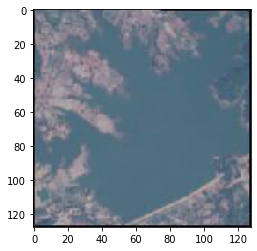

In [0]:
plt.imshow(images_train[0])
plt.show()

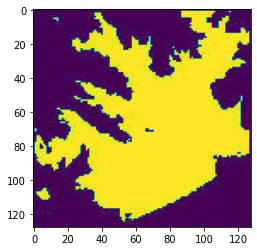

In [0]:
plt.imshow(masks_train[0])
plt.show()

U-NET

In [0]:
image_width = 128
image_height = 128
image_channels = 3
filter_multiplier = 32
epochs = 50

In [0]:
inputs = Input(shape=(image_width, image_height, image_channels))
#1
first_convolution = Conv2D(filters=1*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(inputs)
first_convolution = Conv2D(filters=1*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(first_convolution)
first_pooling = MaxPooling2D(pool_size=(2,2))(first_convolution)
first_pooling = Dropout(0.5)(first_pooling)

#2
second_convolution = Conv2D(filters=2*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(first_pooling)
second_convolution = Conv2D(filters=2*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(second_convolution)
second_pooling = MaxPooling2D(pool_size=(2,2))(second_convolution)
second_pooling = Dropout(0.5)(second_pooling)

#3
third_convolution = Conv2D(filters=4*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(second_pooling)
third_convolution = Conv2D(filters=4*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(third_convolution)
third_pooling = MaxPooling2D(pool_size=(2,2))(third_convolution)
third_pooling = Dropout(0.5)(third_pooling)

#4
fourth_convolution = Conv2D(filters=8*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(third_pooling)
fourth_convolution = Conv2D(filters=8*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(fourth_convolution)
fourth_pooling = MaxPooling2D(pool_size=(2,2))(fourth_convolution)
fourth_pooling = Dropout(0.5)(fourth_pooling)

#5
fifth_convolution = Conv2D(filters=16*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(fourth_pooling)
fifth_convolution = Conv2D(filters=16*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(fifth_convolution)

#6
sixth_deconvolution = Conv2DTranspose(filters=8*filter_multiplier, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(fifth_convolution)
sixth_convolution = concatenate([sixth_deconvolution, fourth_convolution])
sixth_convolution = Dropout(0.5)(sixth_convolution)
sixth_convolution = Conv2D(filters=8*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(sixth_convolution)
sixth_convolution = Conv2D(filters=8*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(sixth_convolution)


#7
seventh_deconvolution = Conv2DTranspose(filters=4*filter_multiplier, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(sixth_convolution)
seventh_convolution = concatenate([third_convolution, seventh_deconvolution])
seventh_convolution = Dropout(0.5)(seventh_convolution)
seventh_convolution = Conv2D(filters=4*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(seventh_convolution)
seventh_convolution = Conv2D(filters=4*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(seventh_convolution)

#8
eigth_deconvolution = Conv2DTranspose(filters=2*filter_multiplier, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(seventh_convolution)
eigth_convolution = concatenate([eigth_deconvolution, second_convolution])
eigth_convolution = Dropout(0.5)(eigth_convolution)
eigth_convolution = Conv2D(filters=2*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(eigth_convolution)
eigth_convolution = Conv2D(filters=2*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(eigth_convolution)

#9
ninth_deconvolution = Conv2DTranspose(filters=1*filter_multiplier, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu' )(eigth_convolution)
ninth_convolution = concatenate([ninth_deconvolution, first_convolution])
ninth_convolution = Dropout(0.5)(ninth_convolution)
ninth_convolution = Conv2D(filters=1*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(ninth_convolution)
ninth_convolution = Conv2D(filters=1*filter_multiplier, kernel_size=(3,3), padding='same', activation='relu' )(ninth_convolution)

#10
output = Conv2D(filters = 1, kernel_size=(1,1), padding='valid', activation='sigmoid')(ninth_convolution)

In [0]:
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
history = model.fit(images_train, masks_train, epochs = epochs, validation_data=(images_test, masks_test))

Epoch 1/50
74/74 [==============================] - 9s 123ms/step - loss: 1.0841 - dice_loss: 0.5318 - val_loss: 0.9667 - val_dice_loss: 0.4173
Epoch 2/50
74/74 [==============================] - 8s 105ms/step - loss: 0.9736 - dice_loss: 0.4649 - val_loss: 0.9211 - val_dice_loss: 0.3908
Epoch 3/50
74/74 [==============================] - 8s 105ms/step - loss: 0.8610 - dice_loss: 0.4001 - val_loss: 0.8489 - val_dice_loss: 0.3683
Epoch 4/50
74/74 [==============================] - 8s 105ms/step - loss: 0.7618 - dice_loss: 0.3499 - val_loss: 0.7986 - val_dice_loss: 0.3062
Epoch 5/50
74/74 [==============================] - 8s 105ms/step - loss: 0.7489 - dice_loss: 0.3421 - val_loss: 0.7250 - val_dice_loss: 0.2769
Epoch 6/50
74/74 [==============================] - 8s 105ms/step - loss: 0.6849 - dice_loss: 0.3088 - val_loss: 0.7363 - val_dice_loss: 0.2652
Epoch 7/50
74/74 [==============================] - 8s 105ms/step - loss: 0.6664 - dice_loss: 0.2988 - val_loss: 0.7960 - val_dice_loss:

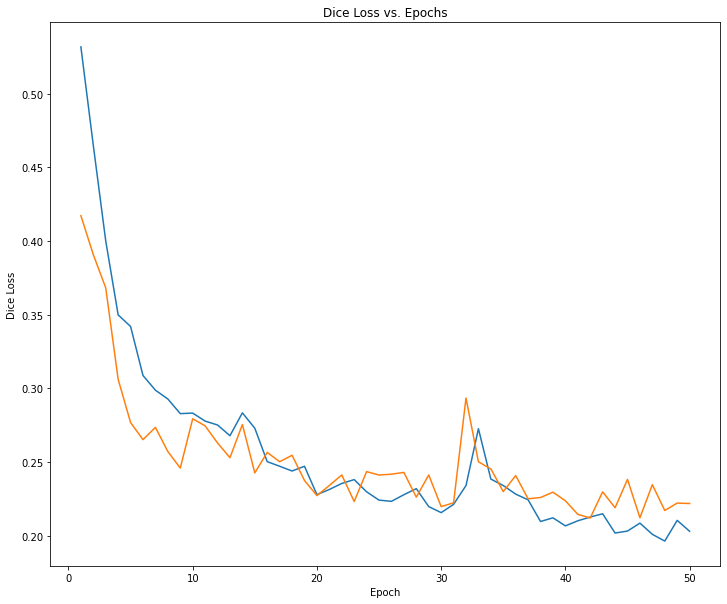

In [0]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']
epochs_range = range(1, epochs+1)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, dice, label='Training')
plt.plot(epochs_range, val_dice, label='Validation')
plt.title('Dice Loss vs. Epochs')
plt.ylabel('Dice Loss')
plt.xlabel('Epoch')
plt.show()

In [0]:
predictions = model.predict(images_test)

In [0]:
predictions = np.mean(predictions, axis=3)

In [0]:
predictions[predictions>=predictions.mean()] = 1
predictions[predictions<predictions.mean()] = 0

In [0]:
predictions = np.stack((predictions,)*3, axis=3)

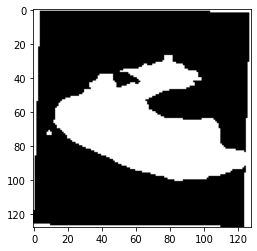

In [0]:
plt.imshow(predictions[1])

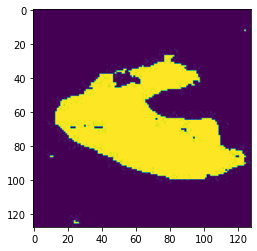

In [0]:
plt.imshow(masks_test[1])

Calculate Water Function

In [0]:
def calculate_water(predicted_mask):
  white = len(predicted_mask[predicted_mask>=.5])
  black = len(predicted_mask[predicted_mask<.5])
  water_percentage = white / (white+black)
  return round(water_percentage,5)

In [0]:
calculate_water(predictions[1])

0.32123

In [0]:
calculate_water(masks_test[1])

0.26013

Calculate Water

In [0]:
water_test = [calculate_water(mask) * 100 for mask in masks_test]
water_predicted = [calculate_water(mask) *100 for mask in predictions]

In [0]:
results = pd.DataFrame({'Image':sorted(images_to_load[round(len(images_to_load)*.8):]),
                        'Original Water Percentage':water_test,
                        'Predicted Water Percentage':water_predicted})

In [0]:
results['Error Percentage'] = 100 * abs(results['Original Water Percentage']-results['Predicted Water Percentage']) / results['Original Water Percentage']

In [0]:
results.sort_values(by='Error Percentage', ascending = False)

In [0]:
results['Error Percentage'].mean()

83.96770910799351